파이썬 딥러닝 텐서플로 ch4. 4 p.182-200

In [2]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

In [31]:
# EuroSAT 위성 사진 데이터셋 로드

DATA_DIR = 'datasets/'

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True,
                                       as_supervised=True,
                                       with_info=True,
                                       data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [32]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='datasets\\eurosat\\rgb\\2.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('ima

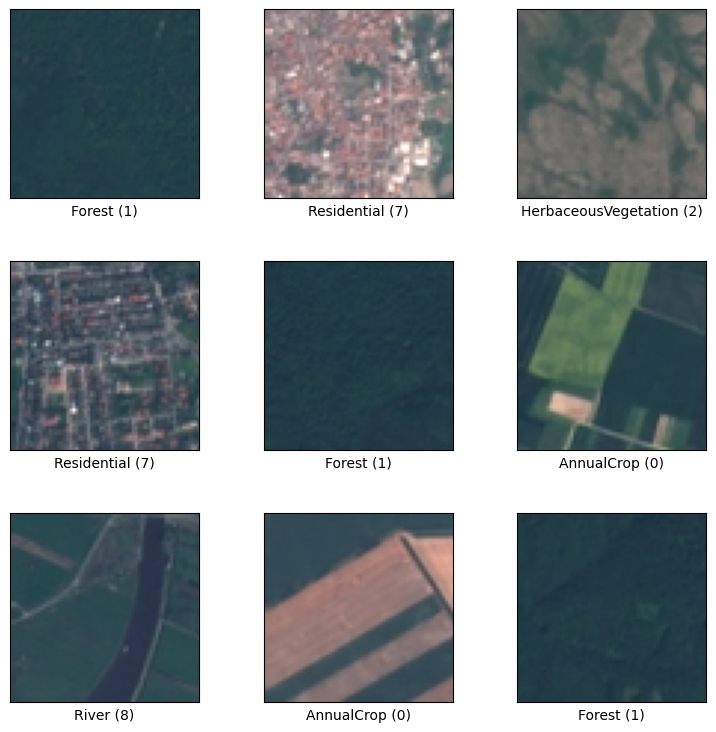

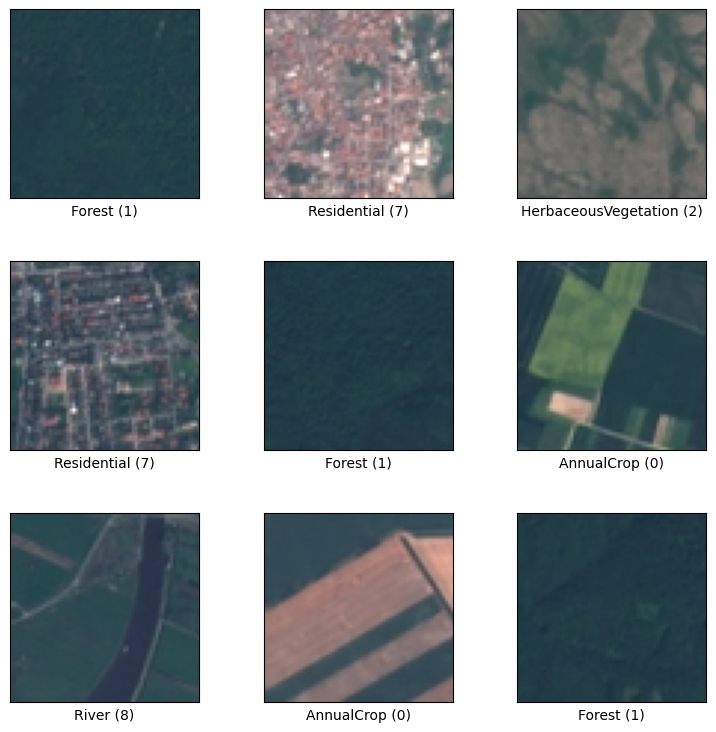

In [33]:
# 샘플 이미지를 메타 정보인 분류 레이블과 함께 화면에 출력 'show_examples' 함수 사용

# 데이터 확인
tfds.show_examples(train_ds, info)

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

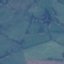
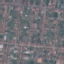
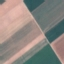
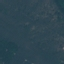
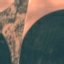
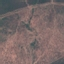
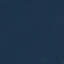
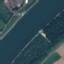
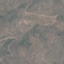
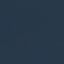

In [34]:
# as_dataframe 함수 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [35]:
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


-> 토지 이용 분류에 해당하는 정답 클래스 개수: 10개

In [36]:
# 숫자 레이블을 활용해 문자열 메타 데이터로 변환
print(info.features["label"].int2str(6))

PermanentCrop


## 4-2. 데이터 전처리
* cast 함수: 자료형 -> float32
입력이미지는 0~255 범위의 픽셀 값을 갖기 때문에 255로 나누어 정규화

* map 함수: 사용자 정의 함수를 매핑하여 텐서플로 데이터셋에 적용하는 메소드
num_parallel_calls 옵션을 오툐튠으로 지정하면 텐서플로 병렬연산 처리를 자동으로 최적화

* shuffle() : 순서를 랜덤하게 섞어줌. -> 모델의 일반화된 성능을 높이기 위해 훈련 데이터셋에서 미니배치를 생성할 때 입력 순서에 무작위성을 부여하는 것

* prefech() : 모델이 훈련을 진행하는 동안 다음에 이벽할 데이터를 불러와서 미리 전처리하도록 시스템을 조율. -> 병렬 처리를 통해 모델 훈련 시간을 단축시켜줌. 단축시켜줌.

In [37]:
# 데이터 전처리 파이프라인
BATCH_SIZE = 640
BUFFER_SIZE = 1000

def preprocess_data(image, label):
  image = tf.cast(image, tf.float32) / 255.  # 0~1 정규화, float32 변환
  return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE) # num_parallel_calls=tf.data.AUTOTUNE :병렬 연산 처리 자동으로 최적화
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

### 4-3. 모델 훈련 및 검증:
배치 정규화, 합성곱, 풀링 레이어로 구성된 유닛 2개 연결, Dense 레이어와 Dropout으로 구성된 최종 분류기를 갖는 딥러닝 모델을 API로 생성

In [38]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

  model = tf.keras.Sequential([

      # Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model

model = build_model()

In [39]:
# 예측 클래스가 10개인 다중 분류 문제에 맞게 손실함수와 평가지표 설정
# 50 epoch 훈련

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data, validation_data=valid_data, epochs=3)

Epoch 1/3
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 560ms/step - accuracy: 0.2397 - loss: 2.7333 - val_accuracy: 0.1872 - val_loss: 2.2546
Epoch 2/3
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 559ms/step - accuracy: 0.4593 - loss: 1.4991 - val_accuracy: 0.1844 - val_loss: 2.2209
Epoch 3/3
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 573ms/step - accuracy: 0.5667 - loss: 1.2439 - val_accuracy: 0.1357 - val_loss: 2.2903


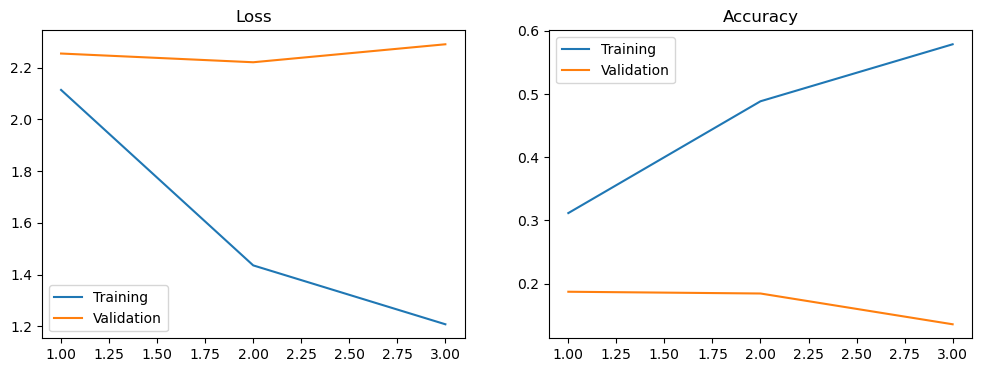

In [40]:
# 손실함수, 정확도 그래프 그리기
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 3)

### 4-4. 데이터 증강* 아마자 분류 문제에서 과대적합을 해소하고, 모델의 일반화된 Robust 한 성능을 확보하는 기법
* 이미지 데이터에 여러 가지 변형을 주어서 훈련 데이터의 다양성을 확보하는 방식, 모델이 새로운 데이터에 대한 예측력을 강화하도록 하는 개념 개념

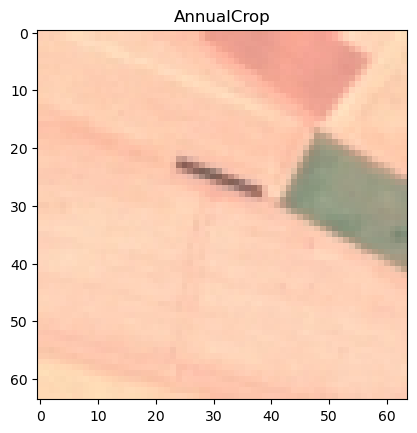

In [41]:
# EuroSAT 데이터셋 중에서 하나의 샘플 이미지 시각화
# 샘플이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [42]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

  fig, axes = plt.subplots(1, 2, figsize=(12, 4))

  axes[0].imshow(original)
  axes[0].set_title('Original')

  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

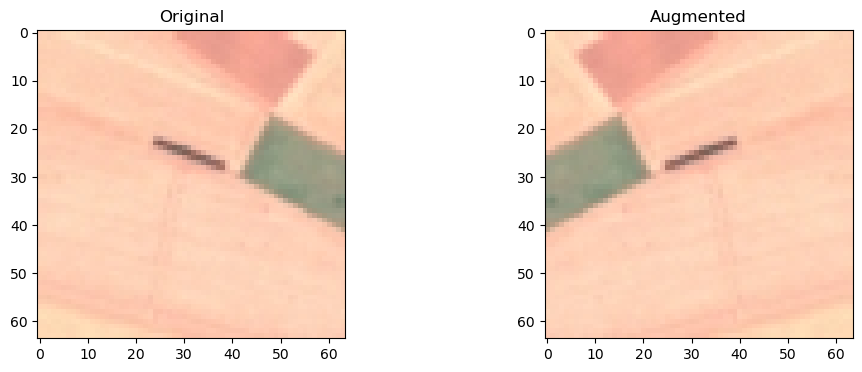

In [43]:
# tf.image 모듈의 flip_left_right 함수 사용하여 이미지를 좌우 방향 뒤집음
# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

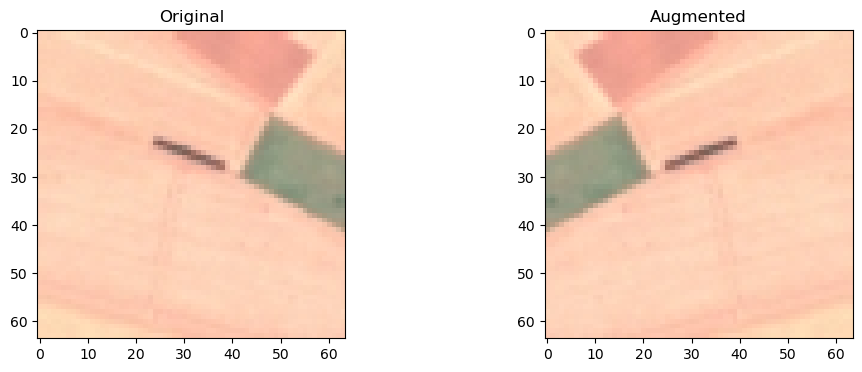

In [44]:
# tf.image 모듈의 flip_left_right 함수 사용하여 이미지를 좌우 방향 뒤집음
# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

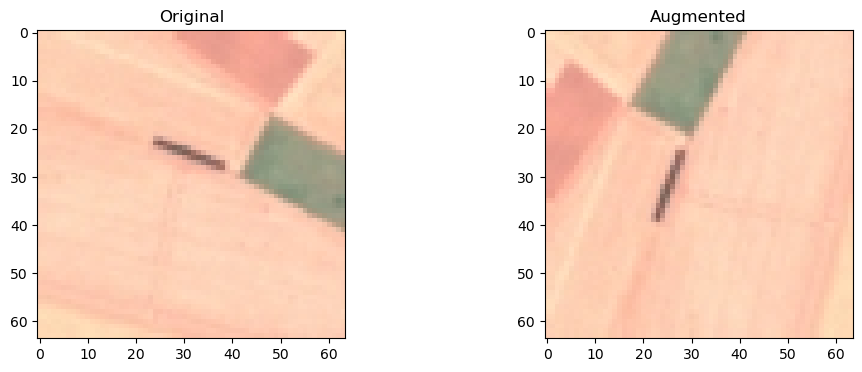

In [45]:
# rot90 함수 사용하여 이미지를 반시계 방향으로 90도 회전
# 회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

In [46]:
# transpose
transpose = tf.image.transpose(image)

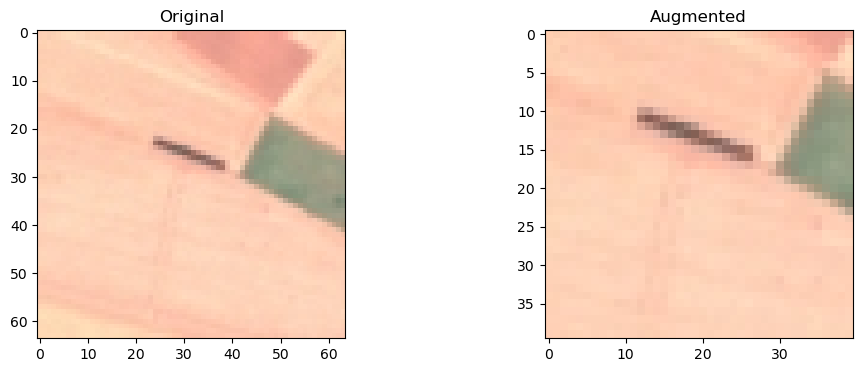

In [47]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

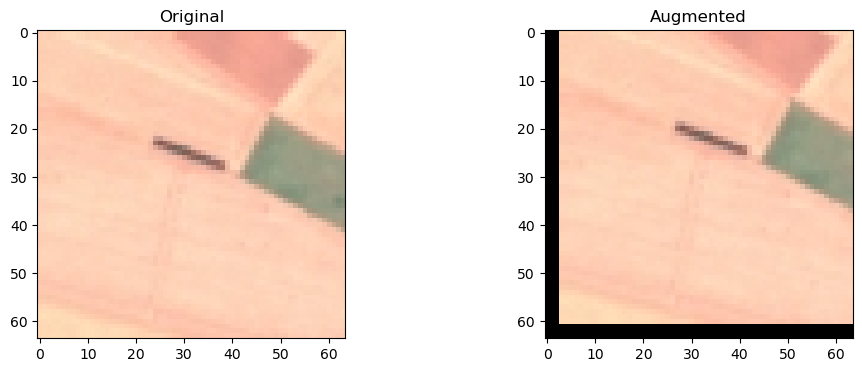

In [48]:
# 이미지 자르기 2
img = tf.image.resize_with_crop_or_pad(image, 64+20, 64+20)  # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

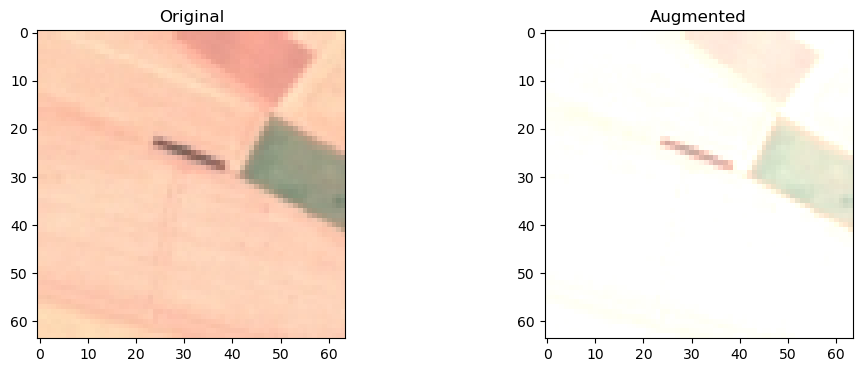

In [49]:
# 이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

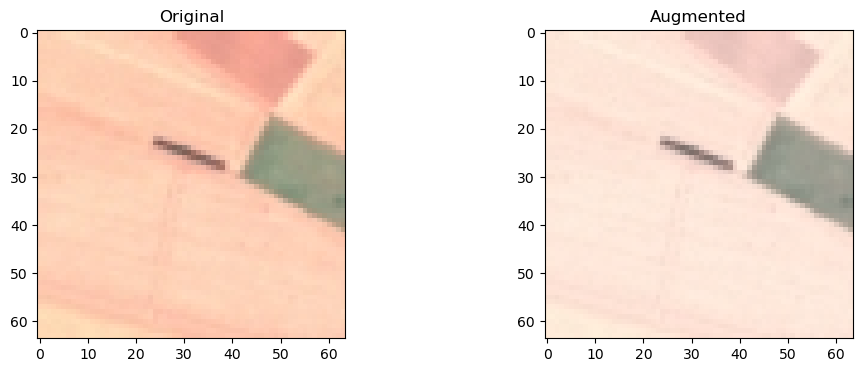

In [50]:
# 이미지 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

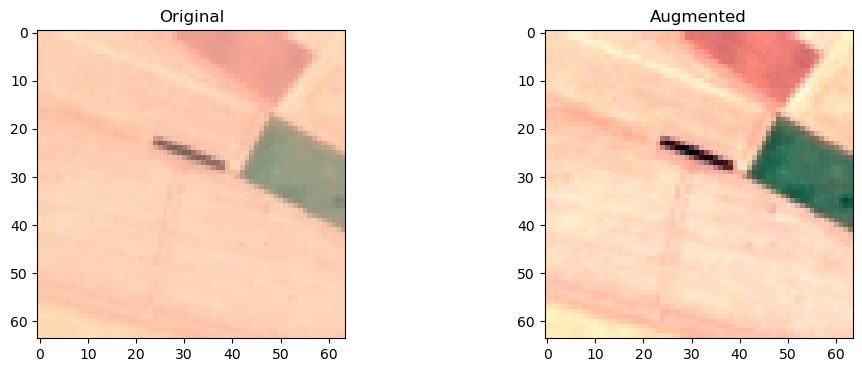

In [51]:
# 이미지 대비
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [52]:
# 이미지 증강 전처리
def data_augmentation(image, label):

  image = tf.image.random_flip_left_right(image)  # 좌우 반전
  image = tf.image.random_flip_up_down(image)  # 상하 반전
  image = tf.image.random_brightness(image, max_delta=0.3)  # 밝기 변화
  image = tf.image.random_crop(image, size=[64, 64, 3])

  image = tf.cast(image, tf.float32) / 255.  # 0~1 정규화

  return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, validation_data=valid_aug, epochs = 3)

Epoch 1/3
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 609ms/step - accuracy: 0.1709 - loss: 2.7868 - val_accuracy: 0.2248 - val_loss: 2.2600
Epoch 2/3
11/34 ━━━━━━━━━━━━━━━━━━━━ 13s 566ms/step - accuracy: 0.3120 - loss: 1.8232

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 3)

### 4-5. ResNet 사전 학습 모델
- 전이 학습
    - 방대한 이미지로 훈련 받은 딥러닝 모델 구조, 가중치를 그대로 가져옴.
    - 모델 끝단에 위치하는 Top 층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가하는 방법 방델

In [ ]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False, # top층 제거해줘야함, 여기에 최종 분류기를 대체해서 추가
                               weights='imagenet',
                               input_shape=[64, 64, 3])

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

In [ ]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

  model = tf.keras.Sequential([

      # Pre-trained Base
      pre_trained_base,
      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

  return model

# 모델 구조
tc_model = build_trainsfer_classifier()
tc_model.summary()